In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
events_raw = np.loadtxt("../tum-vie/events_img_645_655.txt")
#events = np.loadtxt("../data/events.txt")

In [17]:
events_raw[:,0].max()

33671570.0

In [54]:
time_range = np.array([0.0, 1.0]) * 10e+6 + events_raw[:,0].min()
idx_range = [np.searchsorted(events_raw[:,0], time_range[0]), np.searchsorted(events_raw[:,0], time_range[1])]
events = events_raw[idx_range[0]:idx_range[1], :]

In [55]:
events.shape

(10681900, 4)

In [56]:
def filter_patch(events, patch_center, patch_size):
    x_lim = (patch_center[1] - int(patch_size / 2), patch_center[1] + int(patch_size / 2) - 1)
    y_lim = (patch_center[0] - int(patch_size / 2), patch_center[0] + int(patch_size / 2) - 1)

    events_filtered = np.copy(events)
    events_filtered = events_filtered[
        np.logical_and((x_lim[0] <= events_filtered[:, 1]), (events_filtered[:, 1] <= x_lim[1]))]
    events_filtered = events_filtered[
        np.logical_and((y_lim[0] <= events_filtered[:, 2]), (events_filtered[:, 2] <= y_lim[1]))]
    # events_filtered = events_filtered[[(y_lim[0] >= events_range[:,2]) & (events_range[:,2] <= y_lim[1])]
    #vents_filtered = np.array(events_filtered)

    events_filtered[:,1] = (events_filtered[:,1] - patch_center[1] + int(patch_size / 2)).astype(int)
    events_filtered[:,2] = (events_filtered[:,2] - patch_center[0] + int(patch_size / 2)).astype(int)
    
    return events_filtered

In [57]:
def img_from_events(events):
    img_height = int(events[:,2].max()+1)
    img_width = int(events[:,1].max()+1)
    img = np.zeros((img_height, img_width))
    for e in events:
        if e[3] == 1:
            continue
        x = int(e[1])
        y = int(e[2])
        img[y, x] += 1
    return img

In [58]:
patch_center = (360, 640)
patch_size = 720
shape = (patch_size, patch_size)
events = filter_patch(events, patch_center, patch_size)

In [59]:
t_start = events[0, 0]

In [74]:
last_time = np.zeros(shape)
time_diff_dict = {}
dist = 15
warped_shape = (patch_size, 1000)
for e in events:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist:
        continue
    
    if last_time[y, x+dist] != 0:
        speed = dist/(e[0] - last_time[y, x+dist])
        warp_pos_x = int(x + (e[0] - t_start) * speed)
        if warp_pos_x >= warped_shape[1]:
            continue
        if (y, warp_pos_x) in time_diff_dict:
            time_diff_dict[y, warp_pos_x].append(speed)
        else:
            time_diff_dict[y, warp_pos_x] = [speed]

In [119]:
warped_img = np.zeros(warped_shape)
for k in time_diff_dict:
    y = k[0]
    x = k[1]
    if len(time_diff_dict[k]) <= 25:
        continue
    warped_img[y, x] = np.median(time_diff_dict[k])

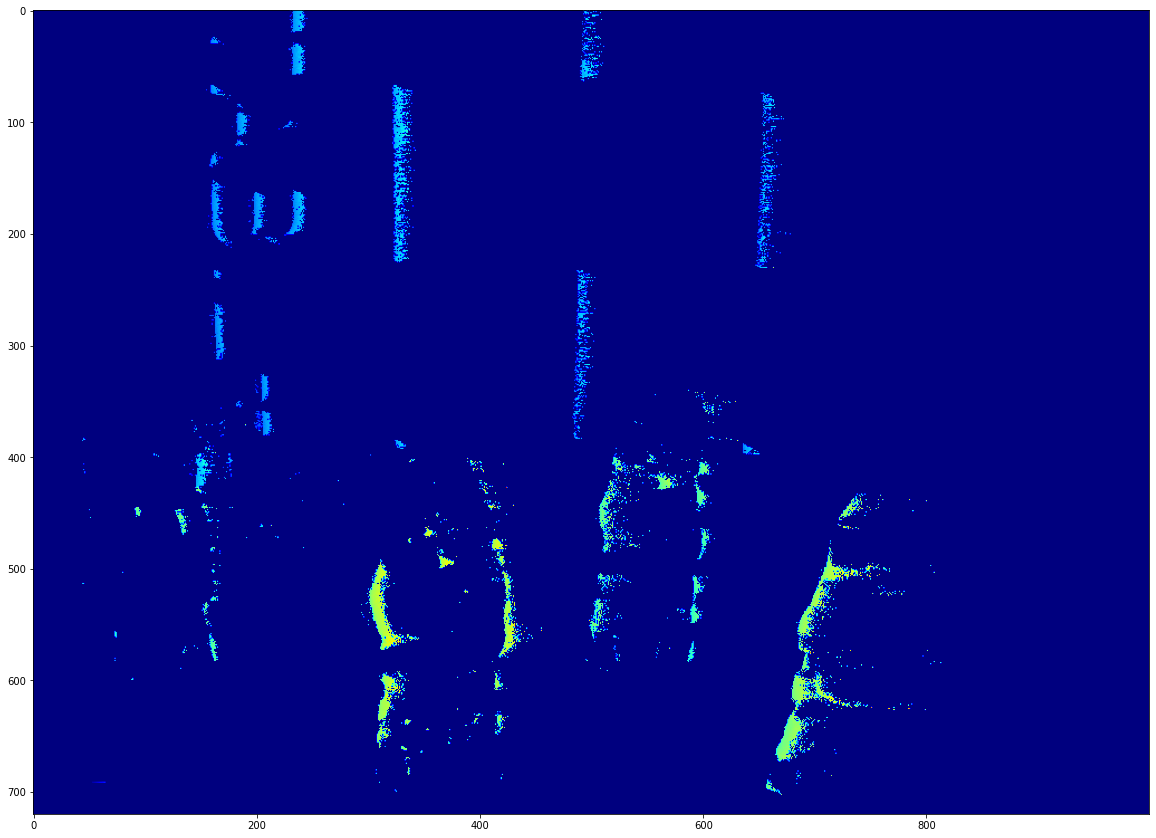

In [120]:
#time_diff_fil = np.ma.masked_where(time_difference < 2, time_difference)
plt.figure(figsize=(20, 20))
plt.imshow(warped_img, cmap="jet")

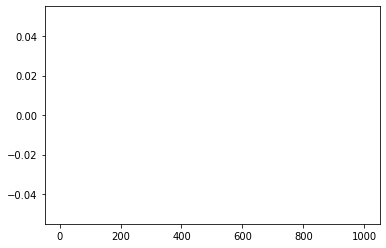

In [121]:
plt.hist(warped_img.flatten(), 100, range=(1, 1000));

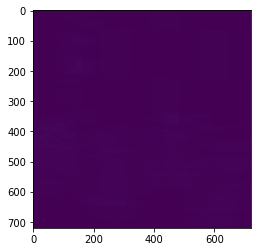

In [122]:
plt.imshow(img_from_events(events))

In [123]:
conv_shape = (10, 10)
conv_stride = (10, 10)
result_shape = (int(warped_img.shape[0]/conv_stride[0]), int(warped_img.shape[1]/conv_stride[1]))
dict_px = {} 
dict_t = {}
for x in range(warped_img.shape[1]):
    for y in range(warped_img.shape[0]):
        if warped_img[y, x] == 0:
            continue

        x_c = int(x / conv_stride[0])
        y_c = int(y / conv_stride[1])

        if (y_c, x_c) in dict_px:
            dict_px[y_c, x_c].append(warped_img[y, x])
        else:
            dict_px[y_c, x_c] = [warped_img[y, x]]

In [124]:
time_diff_med = np.zeros(result_shape)
for k in dict_px:
    y = k[0]
    x = k[1]
    if len(dict_px[k]) <= 1:
        continue
    time_diff_med[y, x] = np.median(dict_px[k])

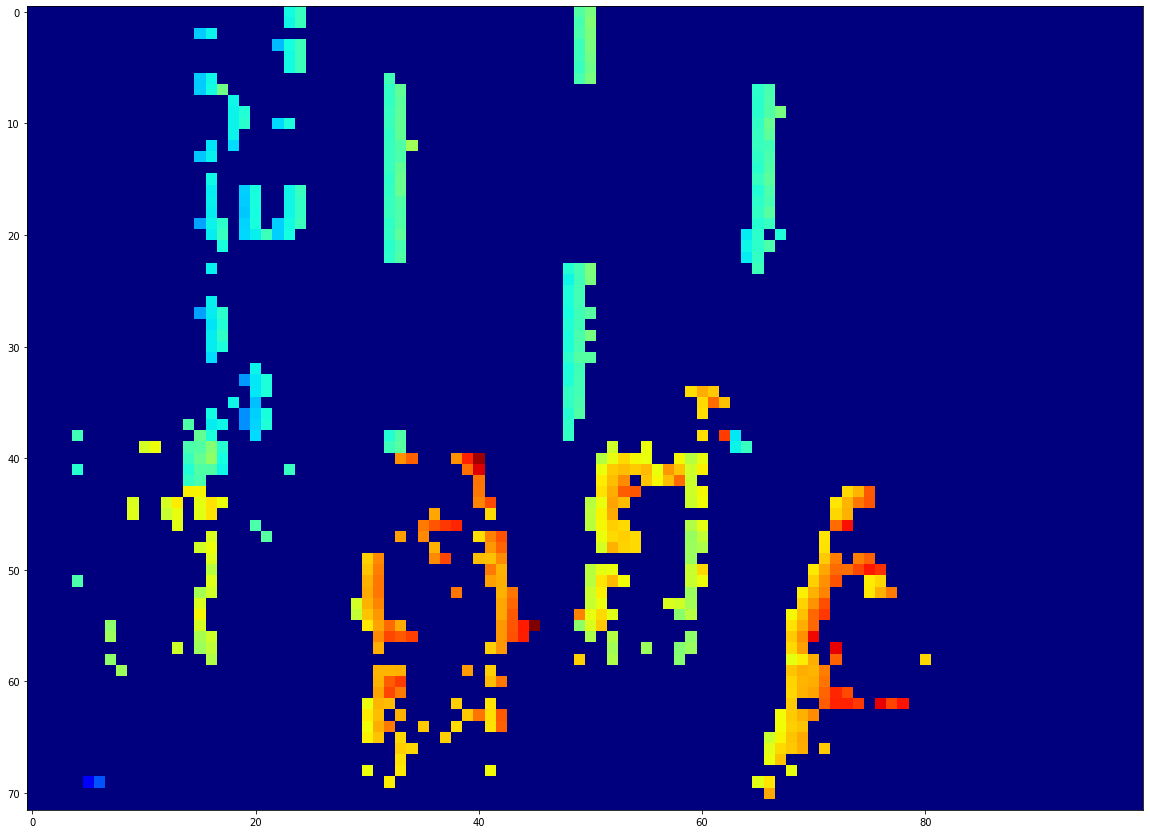

In [125]:
%matplotlib inline
plt.figure(figsize=(20, 20))
m = plt.imshow(time_diff_med, cmap="jet")
#plt.colorbar(mappable=m)

# Conv on the input spikes to reduce variability for fast motions

We can see above that for fast motions, the velocity varies a lot, making the warped image very "spread out" compared to slower motion. A convolution on the input spikes may help mitigating this effect

In [156]:
#perform the convolution
shape = (720, 720)
conv_stride = (5, 5)
conv_shape = (5, 5)
result_shape = (int(shape[0]/conv_stride[0]), int(shape[1]/conv_stride[1]))
spk_count = np.zeros(result_shape)
time_count = np.zeros(result_shape)
spk_thresh = conv_shape[0]*conv_shape[1]*0.66
events_conv = []
for e in events:
    if e[3] == 1:
        continue
    x = int(e[1])
    y = int(e[2])

    x_c = int(x / conv_stride[0])
    y_c = int(y / conv_stride[1])

    spk_count[y_c, x_c] += 1
    time_count[y_c, x_c] += e[0]
    
    if spk_count[y_c, x_c] >= spk_thresh:
        time_avg = time_count[y_c, x_c] / spk_count[y_c, x_c]
        events_conv.append([time_avg, x_c, y_c, e[3]])
        spk_count[y_c, x_c] = 0
        time_count[y_c, x_c] = 0
events_conv = np.array(events_conv)

In [157]:
shape = result_shape

In [158]:
t_start = events[0, 0]

In [159]:
last_time = np.zeros(shape)
time_diff_dict = {}
dist = 7
warped_shape = (int(shape[0]), 600)
for e in events_conv:
    if e[3] == 1:
        continue
    
    x = int(e[1])
    y = int(e[2])
    
    last_time[y, x] = e[0]
    
    if x >= shape[1] - dist:
        continue
    
    if last_time[y, x+dist] != 0:
        if e[0] - last_time[y, x+dist] <= 0:
            continue
        speed = dist/(e[0] - last_time[y, x+dist])
        warp_pos_x = int(x + (e[0] - t_start) * speed)
        if warp_pos_x >= warped_shape[1]:
            continue
        if (y, warp_pos_x) in time_diff_dict:
            time_diff_dict[y, warp_pos_x].append(speed)
        else:
            time_diff_dict[y, warp_pos_x] = [speed]

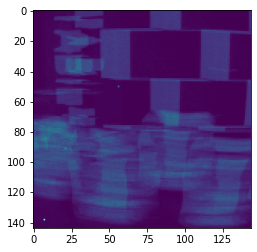

In [160]:
plt.imshow(img_from_events(events_conv))

In [167]:
warped_img = np.zeros(warped_shape)
for k in time_diff_dict:
    y = k[0]
    x = k[1]
    if len(time_diff_dict[k]) <= 30:
        continue
    warped_img[y, x] = np.median(time_diff_dict[k])

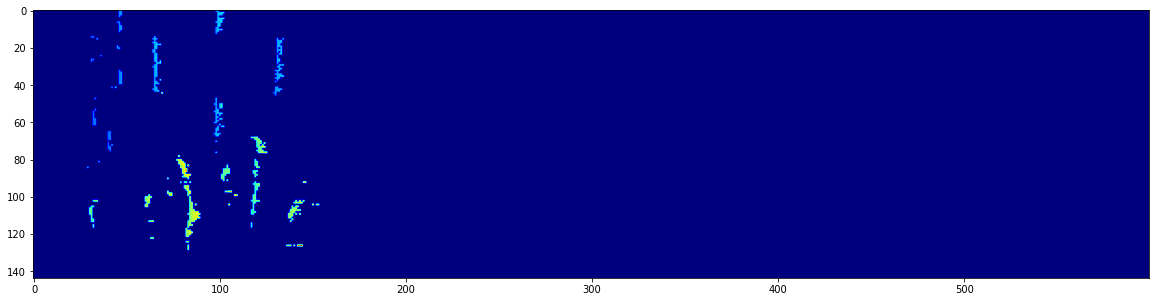

In [168]:
#time_diff_fil = np.ma.masked_where(time_difference < 2, time_difference)
plt.figure(figsize=(20, 20))
plt.imshow(warped_img, cmap="jet")

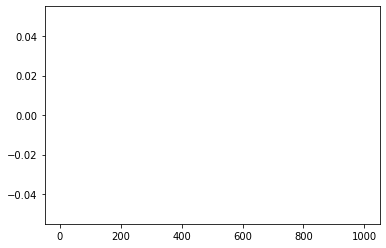

In [148]:
plt.hist(warped_img.flatten(), 100, range=(0.1, 1000));

In [149]:
warped_shape

(360, 600)